# Modelagem de Sistemas Dinâmicos (PME3380)

Simulações dinâmicas para diferentes cenários do trabalho final da discicplina de Modelagem de Sistemas Dinâmicos da Escola Politécnica da USP.

Engenharia Mecânica,Dezembro de 2023

### Configuração do Ambiente e Bibliotecas

Importação das principais biblitoecas que vão ser utilizadas no desenvolvimento da tarefa.

- Numpy para os cálculso de álgebra linear
- Matplotlib para a criação de gráficos
- Scipy para utilizar os métodos de integração numérica



In [79]:
import numpy as np
from scipy.integrate import solve_ivp, odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Descrição do Modelo

Trata-se do controle vetorizado de empuxo para um sistema ativo de pouso de um foguete. Este é tratado como um corpo rígido, e opera segundo a dinâmica previamente calculada.

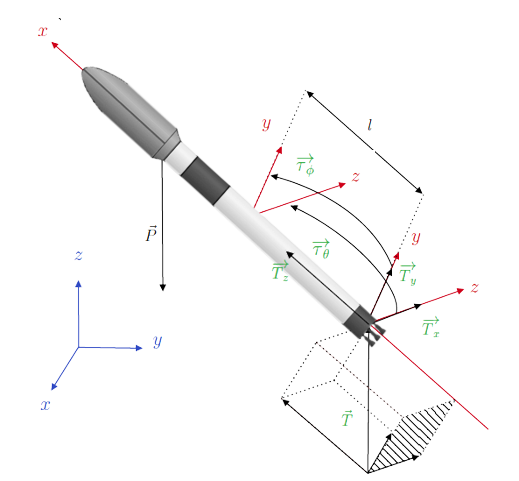

## Parâmetros de Entrada

Primeiramente, definindo as variáveis correspondentes aos parâmetros do problema, tabelados de acordo com o exposto em relatório.

In [80]:
# Definição do empuxo
T = 230.57  # N

# Constantes
g = 9.81  # m/s^2
rho = 1.091  # kg/m^3
d = 0.127  # m
S = np.pi * (d / 2)**2  # m^2
C_D = 0.432
m = 23.545  # kg
J = np.array([[0, 0, 0], [0, 15.97, 0], [0, 0, 15.97]])  # matriz de inércia (kg*m^2)
x_cp = -0.261  # m
L = 3.304  # m (comprimento de referência)
x_cm = 1.052 # m (coordenada do centro de massa)

Em relação aos sinais de entrada

## Simulações Cinemáticas

Definindo funções importantes:

In [81]:
#rotações de euler

def r1(phi):
    return np.array([[1, 0, 0],
                     [0, np.cos(phi), np.sin(phi)],
                     [0, -np.sin(phi), np.cos(phi)]])

def r2(theta):
    return np.array([[np.cos(theta), 0, -np.sin(theta)],
                     [0, 1, 0],
                     [np.sin(theta), 0, np.cos(theta)]])

def r3(psi):
    return np.array([[np.cos(psi), np.sin(psi), 0],
                     [-np.sin(psi), np.cos(psi), 0],
                     [0, 0, 1]])

#inverte matriz
def inverter_matriz(matriz):
  try:

    matriz_inversa = np.linalg.inv(matriz)

    return matriz_inversa

  except np.linalg.LinAlgError:

    return None

#fixo->móvel (mov = Rfix)
def tra_fm(fix, ang):
#lembrando que phi é roll
#theta e psi variam e são =/= 0
  phi, theta, psi = ang
  mov = r1(phi)@r2(theta)@r3(psi)
  mov = mov@fix

  return mov

#móvel->fixo (fix = R^(-1)mov)
def tra_mf(mov, ang):

  phi, theta, psi = ang
  T = inverter_matriz(r1(phi)@r2(theta)@r3(psi))
  fix = T@mov

  return fix

#matriz B
def B(ang):

    phi, theta, psi = ang
    return np.array([[1, np.sin(phi) * np.tan(theta), np.cos(phi) * np.tan(theta)],
                     [0, np.cos(phi), -np.sin(phi)],
                     [0, np.sin(phi) * 1/np.cos(theta), np.cos(phi) * 1/np.cos(theta)]])

#omega fixo->móvel (mov = Bfix)
def tra_fm(fix, ang):

  phi, theta, psi = ang
  mov = B(ang)@fix

  return mov

#omega móvel->fixo (fix = b^(-1)mov)
def tra_mf(mov, ang):

  phi, theta, psi = ang
  fix = inverter_matriz(B(ang))@mov

  return fix


Condições iniciais de velocidade

In [82]:
x = 300
y = 0
z = 0

vx = -10
vy = 0
vz = 0

phi = 0
theta = 0.015
psi = -0.015

wy = 0
wz = 0
wx = 0

mov = [x, y, z, phi, theta, psi, vx, vy, vz, wx, wy, wz]
mov_linear = [x, y, z, theta, psi, vx, vy, vz, wy, wz]

#ang = phi, theta, psi
fix = [50, 0, 0]

control_t = 0

### Equações Dinâmicas


Função linearizada

In [83]:
def linear(t, mov, control_t):
    x, y, z, theta, psi, vx, vy, vz, wy, wz = mov

    #sinais de entrada
    alpha_y = 0.1 * np.sin(10 * t - 10 * np.pi/4)
    alpha_z = 0.1 * np.sin(10 * t - 10 * np.pi/4)

    # Compute other quantities using the provided formulas
    ax = (-5/2 * rho * C_D * d**2 * np.pi) * vx
    ay = T/m * alpha_y + (g - 25/2 * rho * C_D * d**2 * np.pi)/m * psi - 10 * wz
    az = T/m * alpha_z + (-g + 25/2 * rho * C_D * d**2 * np.pi)/m * theta + 10 * wy
    wy_dt = T * x_cm/J[1][1] * alpha_z + (-25/2 * rho * C_D * d**2 * np.pi * x_cp)/J[1][1] * theta
    wz_dt = (-T * x_cm/J[2][2] * alpha_y) + (-25/2 * rho * C_D * d**2 * np.pi * x_cp)/J[2][2] * psi

    return [vx, vy, vz, wy, wz, ax, ay, az, wy_dt, wz_dt]

Função não linearizada

In [84]:
def non_linear(t, mov):
    x, y, z, phi, theta, psi, vx, vy, vz, wx, wy, wz = mov

    # Defina suas variáveis de entrada
    alpha_y = 0.1 * np.sin(10 * t - 10 * np.pi/4)
    alpha_z = 0.1 * np.sin(10 * t - 10 * np.pi/4)

    # Equações de movimento
    ax = wz * vy - wy * vz + 1/m * (-m * g * np.cos(theta) * np.cos(psi) + T * np.cos(alpha_y) * np.cos(alpha_z) + 1/2 * rho * C_D * np.cos(theta) * np.cos(psi) *
                                      (np.pi * (d**2)/4 + L * d * ((np.sin(theta))**2 + (np.sin(psi))**2)**0.5 ) * ( np.cos(theta) * np.cos(psi) * vx + ( np.cos(psi) * np.sin(theta) * np.sin(phi) - np.cos(phi) * np.sin(psi)) * vy + (np.cos(phi) * np.cos(psi) * np.sin(theta) + np.sin(phi) * np.sin(psi)) * vz )**2 )

    ay = - wz * vx + wx * vz + 1/m * ( -m * g * (np.cos(psi) * np.sin(theta) * np.sin(phi) - np.cos(phi) * np.sin(psi)) + T * np.cos(alpha_z) * np.sin(alpha_y) + 1/2 * rho * C_D * (np.cos(psi) * np.sin(theta) * np.sin(phi) - np.cos(phi) * np.sin(psi)) *
                                      (np.pi * (d**2)/4 + L * d * ((np.sin(theta))**2 + (np.sin(psi))**2)**0.5 ) * ( np.cos(theta) * np.cos(psi) * vx + ( np.cos(psi) * np.sin(theta) * np.sin(phi) - np.cos(phi) * np.sin(psi)) * vy + (np.cos(phi) * np.cos(psi) * np.sin(theta) + np.sin(phi) * np.sin(psi)) * vz )**2 )

    az = wy * vx - wx * vy + 1/m * ( -m * g * (np.cos(phi) * np.cos(psi) * np.sin(theta) + np.sin(phi) * np.sin(psi)) + T * np.cos(alpha_y) * np.sin(alpha_z) + 1/2 * rho * C_D * (np.cos(phi) * np.cos(psi) * np.sin(theta) + np.sin(phi) * np.sin(psi)) *
                                      (np.pi * (d**2)/4 + L * d * ((np.sin(theta))**2 + (np.sin(psi))**2)**0.5 ) * ( np.cos(theta) * np.cos(psi) * vx + ( np.cos(psi) * np.sin(theta) * np.sin(phi) - np.cos(phi) * np.sin(psi)) * vy + (np.cos(phi) * np.cos(psi) * np.sin(theta) + np.sin(phi) * np.sin(psi)) * vz )**2 )

    wx_dt = 0  # Adicione essa linha

    wy_dt = 1/(8 * J[1][1]) * ( 8 * wx * wz * J[2][2] + 8 * T * np.cos(alpha_y) * np.sin(alpha_z) * x_cm - rho * C_D * (2 * 2**0.5 * L * d * (2 - np.cos(2*theta) - np.cos(2*psi))**0.5 + np.pi * d**2) *
                                      (np.cos(phi) * np.cos(psi) * np.sin(theta) + np.sin(phi) * np.sin(psi)) * ( np.cos(theta) * np.cos(psi) * vx + ( np.cos(psi) * np.sin(theta) * np.sin(phi) - np.cos(phi) * np.sin(psi)) * vy + (np.cos(phi) * np.cos(psi) * np.sin(theta) + np.sin(phi) * np.sin(psi)) * vz )**2*x_cp)

    wz_dt = 1/(8 * J[2][2]) * (-8 * wy * wx * J[1][1] - 8 * T * np.cos(alpha_z) * np.sin(alpha_y) * x_cm + rho * C_D * (2 * 2**0.5 * L * d * (2 - np.cos(2*theta) - np.cos(2*psi))**0.5 + np.pi * d**2) *
                                      (np.cos(psi) * np.sin(theta) * np.sin(phi) - np.cos(phi) * np.sin(psi)) * ( np.cos(theta) * np.cos(psi) * vx + ( np.cos(psi) * np.sin(theta) * np.sin(phi) - np.cos(phi) * np.sin(psi)) * vy + (np.cos(phi) * np.cos(psi) * np.sin(theta) + np.sin(phi) * np.sin(psi)) * vz )**2*x_cp)


    # Retorne os valores como uma lista
    return [vx, vy ,vz, wx, wy, wz, ax, ay, az, wx_dt, wy_dt, wz_dt]

Execução da simulação dadas as condições de contorno definidas anteriormente

In [85]:
# Tempo de simulação
t_span = [0, 30]  # de 0 a 30 segundos

solution = solve_ivp(linear, t_span, mov_linear, args=(control_t,), method='RK23', t_eval=np.linspace(t_span[0], t_span[1], 10000))

Apresentação de resultados

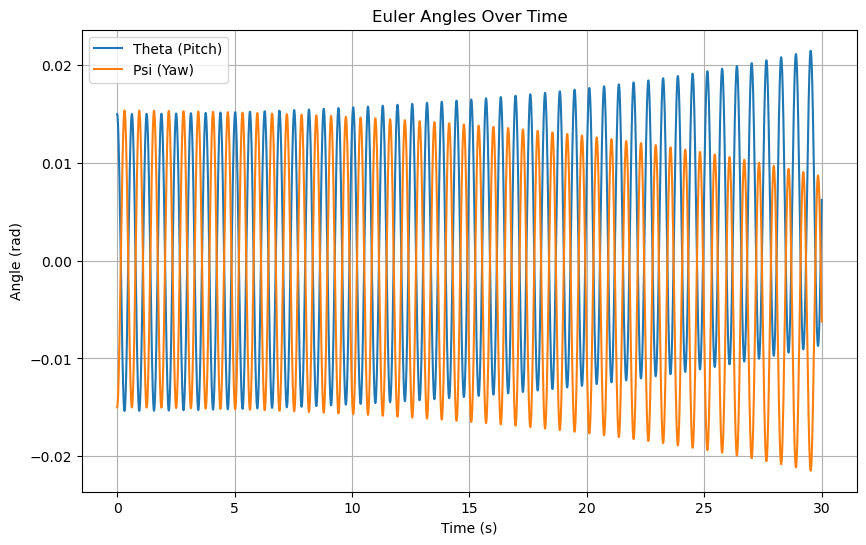

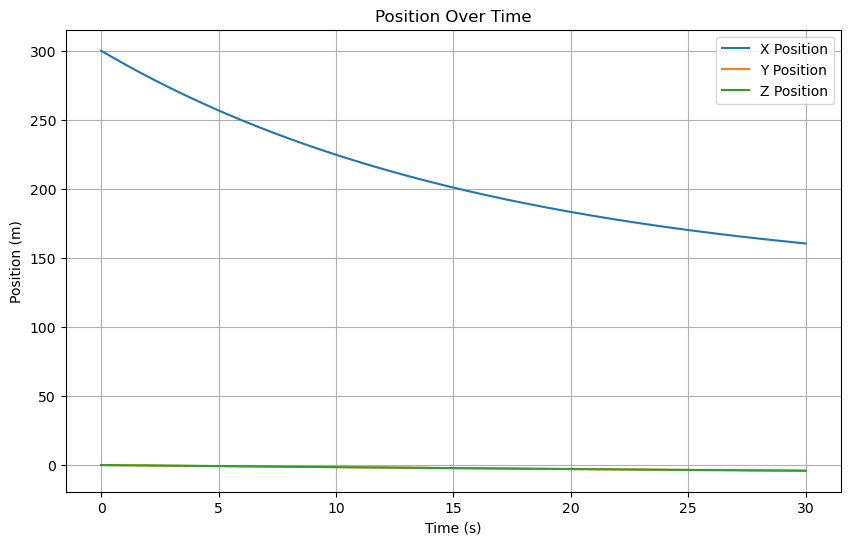

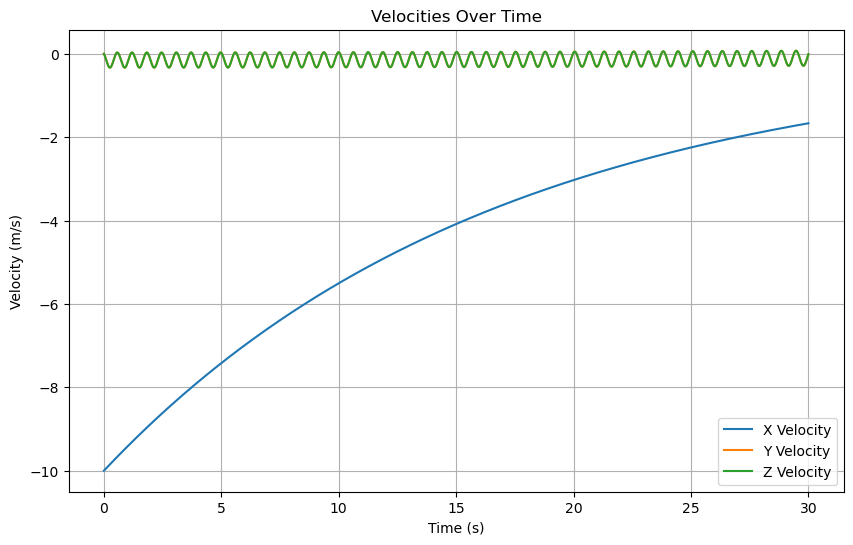

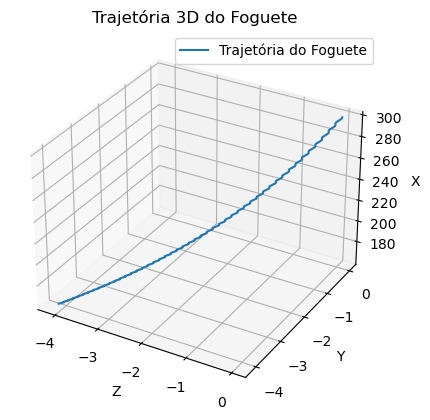

In [86]:
# Extract time and solution data
time = solution.t
angles = solution.y[3:5, :]  # Extracting phi, theta, and psi from the solution
positions = solution.y[0:3, :]  # Extracting x, y, and z from the solution
velocities = solution.y[5:8, :]  # Extracting vx, vy, and vz from the solution

# Plot angles over time
plt.figure(figsize=(10, 6))
plt.plot(time, angles[0, :], label='Theta (Pitch)')
plt.plot(time, angles[1, :], label='Psi (Yaw)')

plt.title('Euler Angles Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.legend()
plt.grid(True)
plt.show()

# Plot positions over time
plt.figure(figsize=(10, 6))
plt.plot(time, positions[0, :], label='X Position')
plt.plot(time, positions[1, :], label='Y Position')
plt.plot(time, positions[2, :], label='Z Position')

plt.title('Position Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid(True)
plt.show()

# Plot velocities over time
plt.figure(figsize=(10, 6))
plt.plot(time, velocities[0, :], label='X Velocity')
plt.plot(time, velocities[1, :], label='Y Velocity')
plt.plot(time, velocities[2, :], label='Z Velocity')

plt.title('Velocities Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.grid(True)
plt.show()

# Criar figura 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extrair dados da solução
x_values = solution.y[0, :]
y_values = solution.y[1, :]
z_values = solution.y[2, :]

# Plotar a trajetória do foguete
ax.plot(z_values, y_values, x_values, label='Trajetória do Foguete')

# Configurações adicionais
ax.set_xlabel('Z')
ax.set_ylabel('Y')
ax.set_zlabel('X')
ax.set_title('Trajetória 3D do Foguete')

# Mostrar a legenda
ax.legend()

# Mostrar o gráfico
plt.show()

In [87]:
# Tempo de simulação
t_span = [0, 30]  # de 0 a 30 segundos

solution = solve_ivp(non_linear, t_span, mov, method='RK23', t_eval=np.linspace(t_span[0], t_span[1], 500))

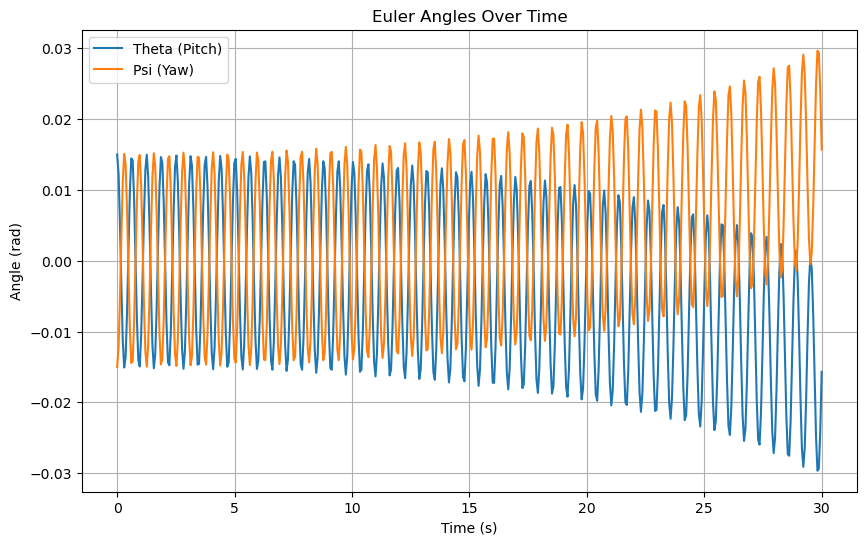

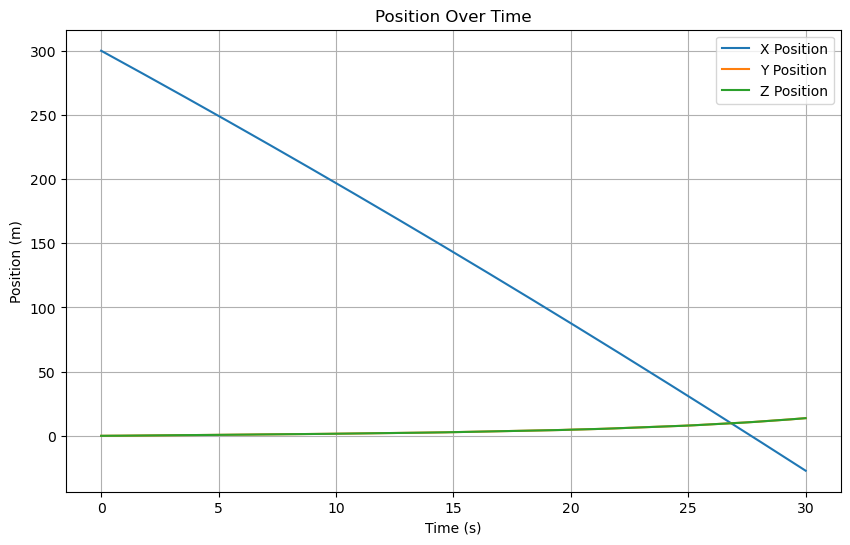

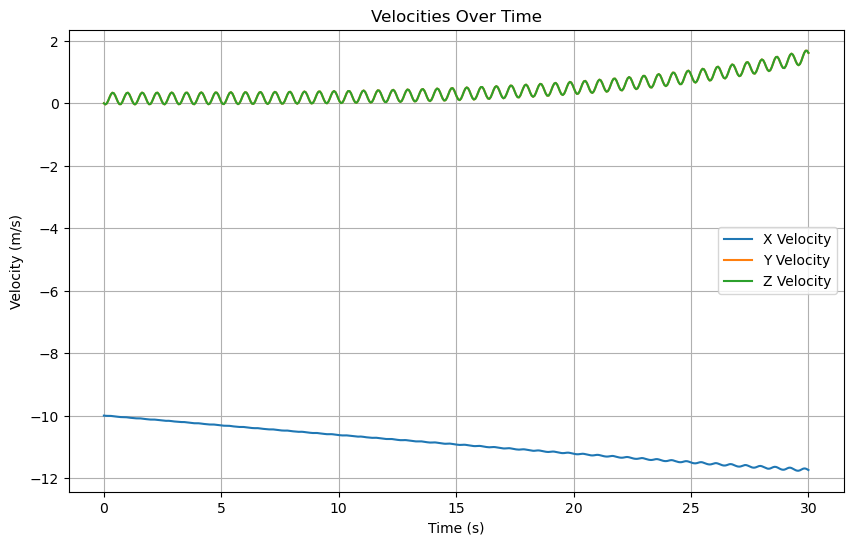

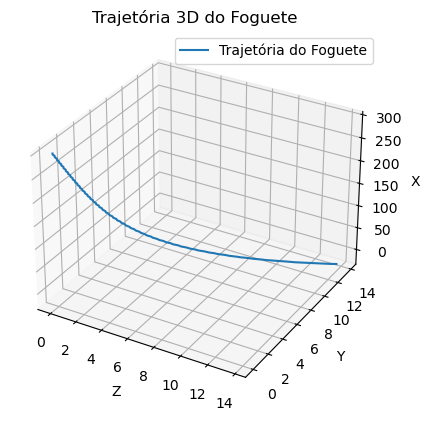

In [88]:
# Extract time and solution data
time = solution.t
angles = solution.y[4:6, :]  # Extracting phi, theta, and psi from the solution
positions = solution.y[0:3, :]  # Extracting x, y, and z from the solution
velocities = solution.y[6:9, :]  # Extracting vx, vy, and vz from the solution

# Plot angles over time
plt.figure(figsize=(10, 6))
plt.plot(time, angles[0, :], label='Theta (Pitch)')
plt.plot(time, angles[1, :], label='Psi (Yaw)')

plt.title('Euler Angles Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.legend()
plt.grid(True)
plt.show()

# Plot positions over time
plt.figure(figsize=(10, 6))
plt.plot(time, positions[0, :], label='X Position')
plt.plot(time, positions[1, :], label='Y Position')
plt.plot(time, positions[2, :], label='Z Position')

plt.title('Position Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid(True)
plt.show()

# Plot velocities over time
plt.figure(figsize=(10, 6))
plt.plot(time, velocities[0, :], label='X Velocity')
plt.plot(time, velocities[1, :], label='Y Velocity')
plt.plot(time, velocities[2, :], label='Z Velocity')

plt.title('Velocities Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.grid(True)
plt.show()

# Criar figura 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extrair dados da solução
x_values = solution.y[0, :]
y_values = solution.y[1, :]
z_values = solution.y[2, :]

# Plotar a trajetória do foguete
ax.plot(z_values, y_values, x_values, label='Trajetória do Foguete')

# Configurações adicionais
ax.set_xlabel('Z')
ax.set_ylabel('Y')
ax.set_zlabel('X')
ax.set_title('Trajetória 3D do Foguete')

# Mostrar a legenda
ax.legend()

# Mostrar o gráfico
plt.show()